
# Simulazione di caching basato su similarità di prompt (CLIP) con due politiche di eviction: LRU e LFU



In [1]:

import random
import itertools
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from collections import defaultdict
from transformers import CLIPTokenizer, CLIPModel
import torch.nn.functional as F
from sklearn.cluster import KMeans


/Users/tella/Workspace/Inria/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



### Setup device (MPS su Mac, altrimenti CPU)


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using Apple MPS device


## Gestione del dataset

In [3]:
from typing import List, Optional, Tuple, Union
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import random

class PromptDatasetManager:
    def __init__(self):
        self.df: pd.DataFrame = None
        self.emb_matrix: np.ndarray = None
        self.prompts_arr: np.ndarray = None
        self.embs_arr: np.ndarray = None
        self.user_to_idx: dict[str, np.ndarray] = {}
        self.session_to_idx: dict[tuple[str,int], np.ndarray] = {}

    def load_local_metadata(self, path: str,
                            max_rows: int = None,
                            load_embeddings: bool = True):
        # 1) Legge parquet con tutte le colonne necessarie
        cols = ['prompt','clip_emb','user_name','timestamp']
        table = pq.read_table(path, columns=cols)
        if max_rows:
            table = table.slice(0, max_rows)
        self.df = table.to_pandas()
        # timestamp → datetime
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        # 2) Matrice embeddings (N, D)
        if load_embeddings:
            self.emb_matrix = np.vstack(self.df['clip_emb'].values).astype(np.float32)
        # 3) Costruisci gli indici per il sampling
        self._build_fast_indices(session_gap=30)

    def _build_fast_indices(self, session_gap: int):
        # 1) Array di prompt/emb per indexing diretto
        N = len(self.df)
        self.prompts_arr = self.df['prompt'].to_numpy(dtype=object)
        self.embs_arr    = self.emb_matrix  # shape (N, D)

        # 2) Mappa user → indici originali
        groups = self.df.groupby('user_name', sort=False).indices
        self.user_to_idx = {
            u: np.asarray(idxs, dtype=np.int32)
            for u, idxs in groups.items()
        }

        # 3) Rimuovo eventuale session_id precedente
        self.df.drop(columns=['session_id'], inplace=True, errors='ignore')

        # 4) Calcolo nuovi session_id solo per righe with user_name non-null
        #    e riallineo su indice completo via reindex
        df_valid = self.df[self.df['user_name'].notna()]

        # groupby su user_name, apply su ciascun gruppo g:
        #   sort per timestamp, diff in minuti, cumsum quando > gap
        sess = df_valid.groupby('user_name', sort=False)['timestamp'].apply(
            lambda ts: (
                ts.sort_values()
                  .diff()
                  .dt.total_seconds()
                  .div(60)
                  .pipe(lambda d: (d.isna() | (d > session_gap)).cumsum())
            )
        )
        # sess è Series con MultiIndex (user_name, original_index)
        sess2 = sess.droplevel(0)  # Serie indexed by original_index

        # riallineo su tutte le righe (index = 0...N-1), filling 0 dove manca
        full_ids = sess2.reindex(self.df.index, fill_value=0).astype(np.int32)
        self.df['session_id'] = full_ids

        # 5) Ora costruisco session_to_idx: mapping (user, session_id) → array di indici
        tup = self.df.groupby(['user_name','session_id'], sort=False).indices
        self.session_to_idx = {
            k: np.asarray(v, dtype=np.int32)
            for k, v in tup.items()
        }


    # -----------------------
    #   FUNZIONI VELOCI
    # -----------------------

    def sample_sessions(
        self,
        num_sessions: Optional[int] = None,
        max_prompts: Optional[int] = None,
        random_order: bool = True
    ) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        Restituisce liste di sessioni:
         - num_sessions=None → tutte le sessioni ([] se <2 prompts)
         - max_prompts=None → tutti i prompt, altrimenti primi max_prompts
         - random_order=True → estrazione casuale delle sessioni
        """
        keys = list(self.session_to_idx.keys())
        if num_sessions is not None:
            if random_order:
                keys = random.sample(keys, num_sessions)
            else:
                keys = sorted(keys)[:num_sessions]

        batches = []
        for k in keys:
            idxs = self.session_to_idx[k]
            if idxs.size < 1:
                continue
            sel = idxs if max_prompts is None else idxs[:max_prompts]
            batches.append((self.prompts_arr[sel], self.embs_arr[sel]))
        return batches

    def sample_user_prompts(
        self,
        num_prompts: Optional[int] = None,
        random_order: bool = True,
        per_user: bool = False
    ) -> Union[List[Tuple[str, np.ndarray]], dict[str, List[Tuple[str, np.ndarray]]]]:
        """
        Sampling di prompt utente:
         - per_user=False → restituisce lista di (prompt, emb)
           - num_prompts=None → tutti i prompt
           - else primi num_prompts o casuali
         - per_user=True → dict user->lista
        """
        results = {} if per_user else []
        for user, idxs in self.user_to_idx.items():
            if idxs.size == 0:
                continue
            order = np.random.permutation(idxs) if random_order else idxs
            sel = order if num_prompts is None else order[:num_prompts]
            items = [(self.prompts_arr[i], self.embs_arr[i]) for i in sel]
            if per_user:
                results[user] = items
            else:
                results.extend(items)
        return results

    def sample_random_prompts(
        self,
        num_prompts: Optional[int] = None,
        random_order: bool = True
    ) -> List[Tuple[str, np.ndarray]]:
        """
        Sampling globale di prompt:
         - num_prompts=None → tutti i prompt (potenzialmente sequenziali se random_order=False)
         - altrimenti random o primi num_prompts
        """
        N = len(self.prompts_arr)
        idxs = np.arange(N)
        if num_prompts is not None:
            if random_order:
                idxs = np.random.choice(N, size=num_prompts, replace=False)
            else:
                idxs = idxs[:num_prompts]
        elif random_order:
            np.random.shuffle(idxs)
        return [(self.prompts_arr[i], self.embs_arr[i]) for i in idxs]

In [4]:
manager = PromptDatasetManager()

In [5]:
manager.load_local_metadata(
    path="/Users/tella/Workspace/Inria/Data/normalized_embeddings.parquet",
    max_rows=None # Limita per testare velocemente
)

In [6]:
from requests import head


print(f"Colonne disponibili: {list(manager.df.columns)}")
print((manager.df.head(5)))

Colonne disponibili: ['prompt', 'clip_emb', 'user_name', 'timestamp', 'session_id']
                                              prompt  \
0  a portrait of a female robot made from code, v...   
1  a portrait of a female robot made from a cloud...   
2      only memories remain, trending on artstation    
3                   dream swimming pool with nobody    
4           a dog doing weights. epic oil painting.    

                                            clip_emb  \
0  [0.0014396037, 0.009074121, -0.07621925, -0.01...   
1  [0.023341777, 0.014913292, -0.10948194, -0.000...   
2  [-0.018536763, -0.029404927, -0.048680052, 0.0...   
3  [0.019796269, -0.025657006, -0.03839434, 0.004...   
4  [0.026751772, 0.0011126306, -0.041311223, 0.04...   

                                           user_name  \
0  0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...   
1  0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...   
2  0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...   
3  019084defdd44d2

In [7]:
sessions = manager.sample_sessions(num_sessions=50, max_prompts=10)
print(f"Loaded {len(sessions)} sessions.")
user_pairs = manager.sample_user_prompts(num_prompts=100, random_order=True, per_user=True)
print(f"Loaded {len(user_pairs)} user pairs.")
random_pairs = manager.sample_random_prompts(num_prompts=200, random_order=True)
print(f"Loaded {len(random_pairs)} random pairs.")


Loaded 50 sessions.
Loaded 10176 user pairs.
Loaded 200 random pairs.


In [8]:
sessions = manager.sample_sessions(num_sessions=None, max_prompts=None)
print(f"Loaded {len(sessions)} sessions.")
user_pairs = manager.sample_user_prompts(num_prompts=None, random_order=True, per_user=True)
print(f"Loaded {len(user_pairs)} user pairs.")
random_pairs = manager.sample_random_prompts(num_prompts=None, random_order=True)
print(f"Loaded {len(random_pairs)} random pairs.")

Loaded 145698 sessions.
Loaded 10176 user pairs.
Loaded 2000000 random pairs.


## Valutazione della similarità intra-sessione, extra-sessione e same-user

In [9]:
def compute_intra_session_sims(
    manager,
    num_sessions: Optional[int] = None,
    max_prompts: Optional[int] = None,
    session_gap: int = 30,
    random_order: bool = True
) -> np.ndarray:
    """
    • Se num_sessions=None: tutte le sessioni, altrimenti ne estrae casuali/ordine.
    • Se max_prompts=None: tutti i prompt di ciascuna sessione, altrimenti limita.
    Ritorna array concatenato di dot‑product tra embeddings consecutive per sessione.
    """
    batches = manager.sample_sessions(
        num_sessions=num_sessions,
        max_prompts=max_prompts,
        random_order=random_order
    )
    sims_list = []
    for _, embs in batches:
        if embs.shape[0] < 2:
            continue
        M = embs if max_prompts is None else embs[:max_prompts]
        # dot tra righe consecutive
        dots = np.einsum('ij,ij->i', M[1:], M[:-1])
        sims_list.append(dots)
    return np.concatenate(sims_list) if sims_list else np.array([])


def compute_user_sims(
    manager,
    num_prompts: Optional[int] = None,
    random_order: bool = True
) -> np.ndarray:
    """
    • Se num_prompts=None: per ogni utente prende tutti i suoi prompt in ordine.
    • Altrimenti estrae num_prompts per utente (random o sequenziale).
    Ritorna array concatenato dei dot‑product tra embeddings consecutive per utente.
    """
    user_dict = manager.sample_user_prompts(
        num_prompts=num_prompts,
        random_order=random_order,
        per_user=True
    )
    sims_list = []
    for items in user_dict.values():
        if len(items) < 2:
            continue
        embs = np.stack([emb for _, emb in items], axis=0)
        dots = np.einsum('ij,ij->i', embs[1:], embs[:-1])
        sims_list.append(dots)
    return np.concatenate(sims_list) if sims_list else np.array([])


def compute_random_sims(
    manager,
    num_prompts: Optional[int] = None,
    random_order: bool = True
) -> np.ndarray:
    """
    • Se num_prompts=None: prende tutti i prompt in ordine (o shuffled se random_order=True).
    • Altrimenti estrae num_prompts a caso o sequenziali.
    Ritorna array di dot‑product tra embeddings consecutive nell’array risultante.
    """
    items = manager.sample_random_prompts(
        num_prompts=num_prompts,
        random_order=random_order
    )
    if len(items) < 2:
        return np.array([])
    embs = np.stack([emb for _, emb in items], axis=0)
    return np.einsum('ij,ij->i', embs[1:], embs[:-1])


In [10]:
intra = compute_intra_session_sims(manager, num_sessions=None, max_prompts=None)
user = compute_user_sims(manager, num_prompts=None, random_order=True)
rand = compute_random_sims(manager, num_prompts=None, random_order=True)

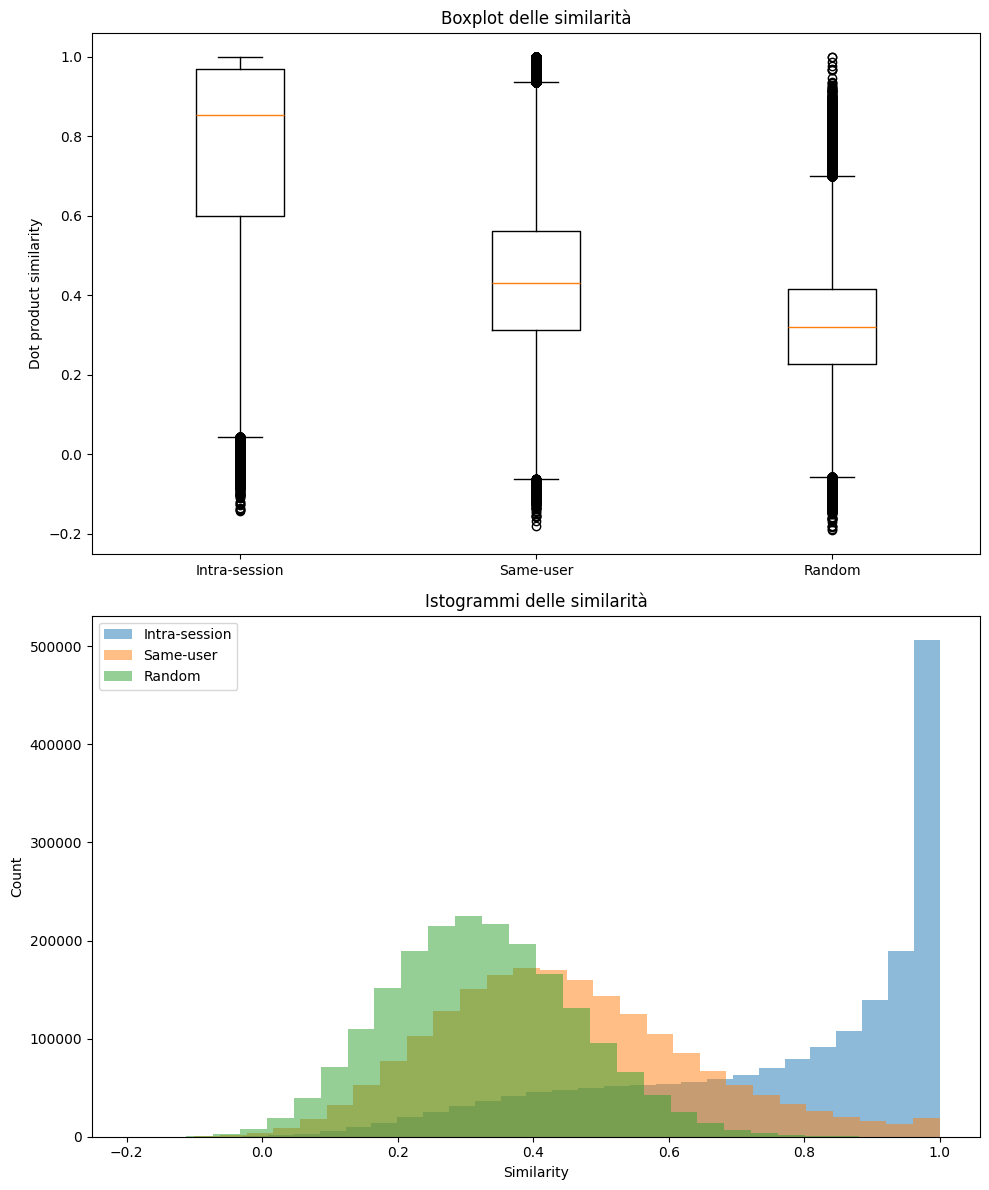

In [11]:

# Histo + boxplot
def plot_distributions(intra, user, rand):
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Boxplot comparativo\    
    axs[0].boxplot([intra, user, rand], tick_labels=['Intra-session', 'Same-user', 'Random'])
    axs[0].set_title('Boxplot delle similarità')
    axs[0].set_ylabel('Dot product similarity')

    # Istogrammi affiancati
    N, bins = 1, 30
    axs[1].hist(intra, bins=bins, alpha=0.5, label='Intra-session')
    axs[1].hist(user, bins=bins, alpha=0.5, label='Same-user')
    axs[1].hist(rand, bins=bins, alpha=0.5, label='Random')
    axs[1].set_title('Istogrammi delle similarità')
    axs[1].set_xlabel('Similarity')
    axs[1].set_ylabel('Count')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_distributions(intra, user, rand)


In [12]:
session_gaps = [5, 10, 20, 30, 60, 120]
sims_by_gap = {
    gap: compute_intra_session_sims(manager, num_sessions=50, session_gap=gap, max_prompts=None)
    for gap in session_gaps
}

In [13]:
means = []
for gap in session_gaps:
    vals = sims_by_gap[gap]
    means.append(np.mean(vals) if vals else 0.0)

plt.figure(figsize=(8,5))
plt.errorbar(
    session_gaps, means,
    marker='o', linestyle='-', capsize=5
)
plt.xlabel("Session gap (minuti)")
plt.ylabel("Mean intra‐session similarity (cosine)")
plt.title("Mean ± STD intra‐session similarity vs session_gap")
plt.grid(True)
plt.show()

best_gap = session_gaps[np.argmax(means)]
print(f"Miglior session_gap = {best_gap} min  (mean sim = {means[session_gaps.index(best_gap)]:.4f})")


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Cache similarity con politiche di eviction

LRU (Least Recently Used) e LFU (Least Frequently Used) e TTL (Time To Live) per la gestione della cache.

In [ ]:
class SimilarityLRUCache:
    """Cache similarity + eviction LRU"""
    def __init__(self, capacity: int, threshold: float):
        self.capacity = capacity
        self.threshold = threshold
        # ordered dict: prompt -> (embedding)
        self.cache = OrderedDict()

    def query(self, prompt: str) -> bool:
        """
        Se esiste un item in cache con sim >= threshold -> hit, aggiorna MRU.
        Altrimenti -> miss.
        """
        q_emb = embed_prompt(prompt)
        best_key, best_sim = None, -1.0
        # cerca best match
        for key, emb in self.cache.items():
            sim = float((emb @ q_emb.T).item())
            if sim > best_sim:
                best_key, best_sim = key, sim
        if best_sim >= self.threshold:
            # hit: aggiorna ordine
            self.cache.move_to_end(best_key)
            return True
        # miss
        self._add(prompt, q_emb)
        return False

    def _add(self, prompt: str, emb: torch.Tensor):
        if len(self.cache) >= self.capacity:
            # rimuovi LRU
            self.cache.popitem(last=False)
        self.cache[prompt] = emb

class SimilarityLFUCache:
    """Cache similarity + eviction LFU"""
    def __init__(self, capacity: int, threshold: float):
        self.capacity = capacity
        self.threshold = threshold
        # store prompt -> embedding, and freq count
        self.cache = {}
        self.freq = defaultdict(int)

    def query(self, prompt: str) -> bool:
        q_emb = embed_prompt(prompt)
        best_key, best_sim = None, -1.0
        for key, emb in self.cache.items():
            sim = float((emb @ q_emb.T).item())
            if sim > best_sim:
                best_key, best_sim = key, sim
        if best_sim >= self.threshold:
            # hit: incrementa freq
            self.freq[best_key] += 1
            return True
        # miss
        self._add(prompt, q_emb)
        return False

    def _add(self, prompt: str, emb: torch.Tensor):
        if len(self.cache) >= self.capacity:
            # rimuovi LFU
            min_freq = min(self.freq.values())
            # trova una chiave con freq minima
            for key, f in list(self.freq.items()):
                if f == min_freq:
                    del self.cache[key]
                    del self.freq[key]
                    break
        self.cache[prompt] = emb
        self.freq[prompt] = 1

class SimilarityTTLCache:
    """Cache similarity + eviction TTL (in numero di richieste)"""
    def __init__(self, capacity: int, threshold: float, ttl: int):
        self.capacity = capacity
        self.threshold = threshold
        self.ttl = ttl
        self.cache = {}    # prompt -> emb (1‑D tensor)
        self.seen = {}     # prompt -> last_seen_request_index

    def query(self, prompt: str, t: int) -> bool:
        # 1) expire old entries
        expired = [p for p, ts in self.seen.items() if t - ts > self.ttl]
        for p in expired:
            del self.cache[p]
            del self.seen[p]

        # 2) similarity search
        q_emb = embed_prompt(prompt).squeeze()
        best_key, best_sim = None, -1.0
        for key, emb in self.cache.items():
            emb = emb.squeeze()
            sim = F.cosine_similarity(q_emb.unsqueeze(0), emb.unsqueeze(0), dim=1).item()
            if sim > best_sim:
                best_sim, best_key = sim, key

        if best_sim >= self.threshold:
            self.seen[best_key] = t
            return True

        # MISS: aggiungi (ed eventualmente evict)
        if len(self.cache) >= self.capacity:
            oldest = min(self.seen, key=lambda k: self.seen[k])
            del self.cache[oldest]; del self.seen[oldest]
        self.cache[prompt] = q_emb
        self.seen[prompt] = t
        return False



### Chaching test

In [ ]:
random.seed(42)
NUM_REQUESTS  = 1500      # numero di richieste da simulare
CACHE_SIZE    = 500      # dimensione cache
SIM_THRESHOLD = 0.8      # soglia di similarità
TTL_VALUES    = [10, 50, 100, 200]  # diversi TTL da testare

# prepariamo prompt generator
prompt_fn = manager.retRandomPrompt()

# funzioni di simulazione
def simulate_standard(cache_obj):
    hits = 0
    for _ in range(NUM_REQUESTS):
        p = prompt_fn()
        if cache_obj.query(p):
            hits += 1
    return hits / NUM_REQUESTS

def simulate_ttl(ttl):
    cache = SimilarityTTLCache(CACHE_SIZE, SIM_THRESHOLD, ttl)
    hits = 0
    for t in range(NUM_REQUESTS):
        p = prompt_fn()
        if cache.query(p, t):
            hits += 1
    return hits / NUM_REQUESTS

# esegui simulazioni
results = {}

# LRU e LFU
results["LRU"] = simulate_standard(SimilarityLRUCache(CACHE_SIZE, SIM_THRESHOLD))
results["LFU"] = simulate_standard(SimilarityLFUCache(CACHE_SIZE, SIM_THRESHOLD))

# TTL per vari parametri
for ttl in TTL_VALUES:
    results[f"TTL={ttl}"] = simulate_ttl(ttl)


KeyboardInterrupt: 

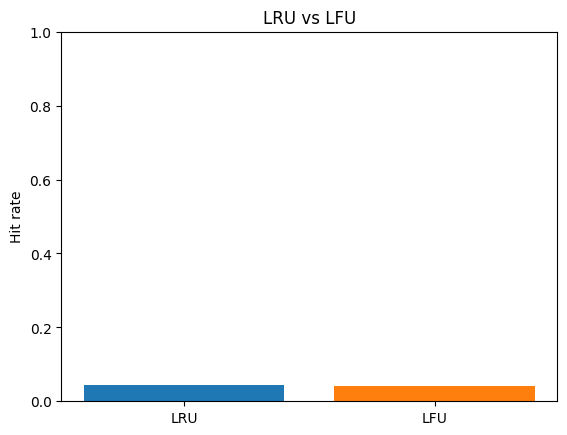

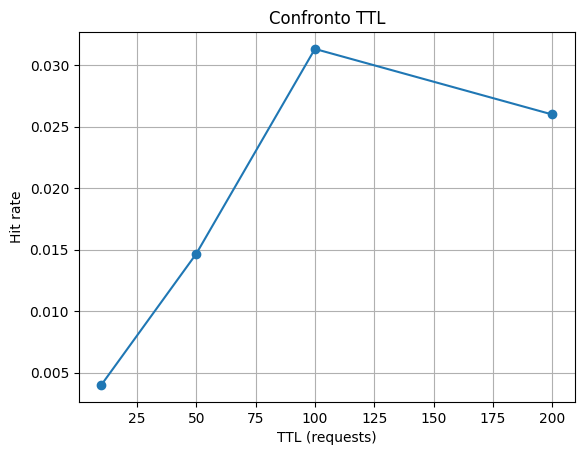

    policy  hit_rate
0      LRU  0.044667
1      LFU  0.040667
2   TTL=10  0.004000
3   TTL=50  0.014667
4  TTL=100  0.031333
5  TTL=200  0.026000


In [ ]:
# stampa tabella
df_res = pd.DataFrame([
    {"policy": k, "hit_rate": v} for k, v in results.items()
])

# separa LRU/LFU
plt.figure()
for pol in ["LRU", "LFU"]:
    hr = df_res[df_res.policy==pol].hit_rate.values[0]
    plt.bar(pol, hr)
plt.ylim(0,1)
plt.ylabel("Hit rate")
plt.title("LRU vs LFU")
plt.show()

# plot TTL
plt.figure()
ttl_rows = df_res[df_res.policy.str.startswith("TTL=")]
vals = [float(x.split("=")[1]) for x in ttl_rows.policy]
hrs  = ttl_rows.hit_rate.tolist()
plt.plot(vals, hrs, marker="o")
plt.xlabel("TTL (requests)")
plt.ylabel("Hit rate")
plt.title("Confronto TTL")
plt.grid(True)
plt.show()

print(df_res)


Caricati 100 prompt per la simulazione.
Simulazione LRU: cap=5, th=0.7
Simulazione LRU: cap=5, th=0.8
Simulazione LRU: cap=5, th=0.9
Simulazione LRU: cap=10, th=0.7
Simulazione LRU: cap=10, th=0.8
Simulazione LRU: cap=10, th=0.9
Simulazione LRU: cap=20, th=0.7
Simulazione LRU: cap=20, th=0.8
Simulazione LRU: cap=20, th=0.9
Simulazione LRU: cap=50, th=0.7
Simulazione LRU: cap=50, th=0.8
Simulazione LRU: cap=50, th=0.9


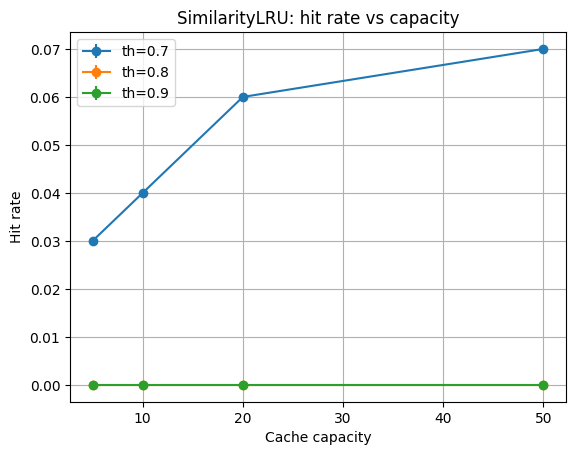

In [ ]:
def simulate_cache(cache_cls, capacity, threshold, workload, num_runs=3):
    metrics = {'hit_rate': [], 'evictions': [], 'comparisons': []}
    for _ in range(num_runs):
        cache = cache_cls(capacity=capacity, threshold=threshold)
        hits = evictions = comparisons = 0
        # opzionale: aggiungi cache.last_comparisons e cache.eviction_count
        for t, p in enumerate(workload):
            if cache.query(p):
                hits += 1
            # evictions += cache.eviction_count_delta
            # comparisons += cache.last_comparisons
        n = len(workload)
        metrics['hit_rate'].append(hits / n)
        metrics['evictions'].append(evictions)
        metrics['comparisons'].append(comparisons)
    # ritorna media e std
    return {
      k: (np.mean(v), np.std(v)) for k, v in metrics.items()
    }

# 1) prepara workload & embedding cache
raw_prompts = manager.getPrompts(limit=100, shuffle=True)
# precompute embeddings to speed up
emb_cache = {p: embed_prompt(p) for p in raw_prompts}
print (f"Caricati {len(raw_prompts)} prompt per la simulazione.")
# 2) definisci parametri
capacities = [5, 10, 20, 50]
thresholds = [0.7, 0.8, 0.9]

# 3) sweep su LRU
results = {}
for cap, th in itertools.product(capacities, thresholds):
    print(f"Simulazione LRU: cap={cap}, th={th}")
    workload = raw_prompts[:]  # o un sottoinsieme
    metrics = simulate_cache(SimilarityLRUCache, cap, th, workload)
    results[(cap, th)] = metrics

# 4) plot hit_rate vs capacity (una linea per threshold)
plt.figure()
for th in thresholds:
    rates = [results[(cap,th)]['hit_rate'][0] for cap in capacities]
    stds  = [results[(cap,th)]['hit_rate'][1] for cap in capacities]
    plt.errorbar(capacities, rates, yerr=stds, marker='o', label=f'th={th}')
plt.xlabel("Cache capacity")
plt.ylabel("Hit rate")
plt.title("SimilarityLRU: hit rate vs capacity")
plt.legend()
plt.grid(True)
plt.show()


Feature importance (η²):
  user_corr      → 0.7709
  session_corr   → 0.7492


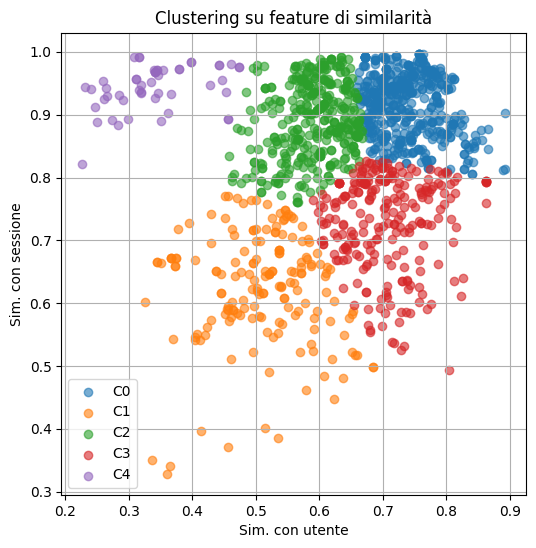

In [ ]:
# --- 1) Usa getSessionsPrompts per il gap di 30'
# manager.getSessionsPrompts(session_gap, limit, shuffle)
user_sessions = manager.getSessionsPrompts(session_gap=30, limit=2, shuffle=False)

# --- 2) Costruisci un DataFrame "flat" sessionale
rows = []
for user, sessions in user_sessions.items():
    for sess_id, prompts in sessions.items():
        for p in prompts:
            rows.append({
                'user_name': user,
                'prompt': p,
                'session_id': sess_id
            })
sess_df = pd.DataFrame(rows)

# --- 3) Calcola embedding per ogni prompt
# Nota: se hai molti duplicati, potresti dedup e poi merge, ma per chiarezza:
sess_df['emb'] = sess_df['prompt'].apply(lambda p: embed_prompt(p).squeeze())

# --- 4) Costruisci i prototipi medi
user_proto = sess_df.groupby('user_name')['emb'] \
                    .apply(lambda embs: torch.stack(embs.tolist()).mean(0))
session_proto = sess_df.groupby('session_id')['emb'] \
                       .apply(lambda embs: torch.stack(embs.tolist()).mean(0))

# funzione di similarità
def cos_sim(a, b):
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0), dim=1).item()

# --- 5) Calcola le due feature
sess_df['user_corr'] = sess_df.apply(
    lambda r: cos_sim(r['emb'], user_proto.loc[r['user_name']]),
    axis=1
)
sess_df['session_corr'] = sess_df.apply(
    lambda r: cos_sim(r['emb'], session_proto.loc[r['session_id']]),
    axis=1
)

# --- 6) Clustering (es. KMeans)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
sess_df['cluster'] = kmeans.fit_predict(sess_df[['user_corr','session_corr']])

# --- 7) η² per variabili numeriche
def eta_squared(x: pd.Series, clusters: pd.Series) -> float:
    mu = x.mean()
    ss_between = sum(
        (clusters == cl).sum() * (x[clusters == cl].mean() - mu)**2
        for cl in clusters.unique()
    )
    ss_total = ((x - mu)**2).sum()
    return float(ss_between / ss_total) if ss_total else 0.0

features = ['user_corr', 'session_corr']
etas = {f: eta_squared(sess_df[f], sess_df['cluster']) for f in features}

# --- 8) Risultati
print("Feature importance (η²):")
for feat, score in sorted(etas.items(), key=lambda kv: kv[1], reverse=True):
    print(f"  {feat:14s} → {score:.4f}")

# --- 9) (Opzionale) Scatter plot
plt.figure(figsize=(6,6))
for cl in range(n_clusters):
    sub = sess_df[sess_df['cluster']==cl]
    plt.scatter(sub['user_corr'], sub['session_corr'], alpha=0.6, label=f'C{cl}')
plt.xlabel("Sim. con utente")
plt.ylabel("Sim. con sessione")
plt.title("Clustering su feature di similarità")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def print_similarity_examples(
    manager,
    num_queries: int = 5,
    search_limit: int = 1000,
    threshold: float = 0.85
):
    """
    Estrae `search_limit` prompt dal manager, ne campiona `num_queries` come 
    domande, calcola embedding e per ognuna trova nel pool il prompt più simile 
    (escludendo se stesso). Se la similarità ≥ threshold, lo stampa.
    """
    # 1) Prendo un pool di prompt da cercare
    pool = manager.getPrompts(limit=search_limit, shuffle=True)
    if len(pool) < num_queries + 1:
        raise ValueError("Pool troppo piccolo per estrarre le query")

    # 2) Scelgo le query
    queries = random.sample(pool, num_queries)

    # 3) Pre-calcolo tutti gli embedding in un dict
    emb_dict = {p: embed_prompt(p).squeeze() for p in pool}

    print(f"=== Examples of prompt similarity (threshold={threshold}) ===\n")
    # 4) Per ogni query cerco il match migliore
    for q in queries:
        q_emb = emb_dict[q]
        best_p, best_sim = None, -1.0
        for p, emb in emb_dict.items():
            if p == q:
                continue
            sim = float(F.cosine_similarity(q_emb.unsqueeze(0), emb.unsqueeze(0), dim=1).item())
            if sim > best_sim:
                best_sim, best_p = sim, p

        # 5) Se supera la soglia, stampo; altrimenti avviso che non ho trovato
        print(f"Query: \"{q}\"")
        if best_sim >= threshold:
            print(f" → Similar: \"{best_p}\"  (sim = {best_sim:.3f})\n")
        else:
            print(f" → Nessun match ≥ threshold (best sim = {best_sim:.3f})\n")

print_similarity_examples(
    manager,
    num_queries=3,     # quante query random
    search_limit=5000,  # dimensione del pool in cui cercare
    threshold=0.7     # soglia minima di similarità per conside­rare un buon match
)


=== Examples of prompt similarity (threshold=0.7) ===

Query: "black color, stock image "
 → Similar: "black png "  (sim = 0.870)

Query: "robot ninja mask helmet metal gear solid training suit swat commando, aesthetic octane render, 8 k hd resolution, by ilya kuvshinov and cushart krentz and gilleard james, by carl warner and jim woodring, trending on artstation : 1. 5, sweet joy harmony color scheme "
 → Similar: " robot ninja helmet mask fantasy art overwatch and heartstone Video game icon, 2d game art gta cover , official fanart behance hd artstation by Jesper Ejsing, by RHADS, Makoto Shinkai and Lois van baarle, ilya kuvshinov, rossdraws "  (sim = 0.725)

Query: "a painting of a boy in a crystal box watching a colorful sunrise futuristic city surrounded by clouds, cyberpunk art by yoshitaka amano and alena aenami, cg society contest winner, retrofuturism, matte painting, apocalypse landscape, cityscape "
 → Nessun match ≥ threshold (best sim = 0.538)

